# SINMOD 3D SPDE model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse, linalg as sli
from scipy.sparse.linalg import spsolve, splu, spsolve_triangular
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sksparse.cholmod import cholesky
from datetime import datetime
from scipy.optimize import minimize
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import plot
import rpy2.robjects as robj
from rpy2.robjects.packages import importr
from scipy.stats import multivariate_normal as mvn
from scipy.stats import norm
inla = importr("INLA")
robj.r('inla.setOption("smtp" = "pardiso", pardiso.license = "~/OneDrive - NTNU/host_2020/pardiso.lic")')
robj.r["inla.getOption"]("smtp")

'pardiso'


In [3]:
import netCDF4
import datetime

fp='data/samples_2020.05.01.nc'
nc = netCDF4.Dataset(fp)
timestamps = [datetime.datetime(2020,5,1,0) + datetime.timedelta(minutes=x) for x in nc['time'][:]*24*60]

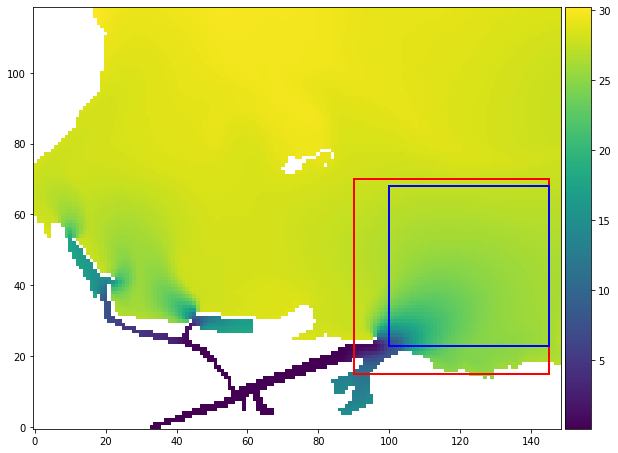

In [4]:
import matplotlib.patches as patches
fig, ax = plt.subplots( figsize=(10,10) )
im = ax.imshow(nc['salinity'][0,0,:,:],origin="lower")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
rect = patches.Rectangle((90, 15), 55, 55, linewidth=2, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((100, 23), 45, 45, linewidth=2, edgecolor='b', facecolor='none')
fig.colorbar(im,cax=cax)
ax.add_patch(rect)
ax.add_patch(rect2)


plt.show()

In [5]:
xdom = np.arange(100,145)
ydom = np.arange(23,23+45)
zdom = np.array([1,3,5,7,9,11,13,15,17,19,20,21,22,23,24,25,26,27,28,29])
data = np.array(nc['salinity'][:,zdom,ydom,xdom])
x = np.array(nc['xc'][xdom])
y = np.array(nc['yc'][ydom])
z = np.array(nc['zc'][zdom])
A = x.max()-x.min()
B = y.max()-y.min()
C = z.max()-z.min()
M = 45
N = 45
P = 20
hx = A/(M-1)
hy = B/(N-1)
hz = C/(P-1)
# Grid
sx, sy, sz = np.meshgrid(x,y,z)
sx = sx.flatten()
sy = sy.flatten()
sz = sz.flatten()
data = data.swapaxes(1,3).swapaxes(1,2).reshape(data.shape[0],M*N*P).swapaxes(0,1)
Dv = hx*hy*hz* sparse.eye(M*N*P)
iDv = sparse.diags(1/Dv.diagonal())

In [6]:
lon = np.array(nc['gridLons'][:,:])
lat = np.array(nc['gridLats'][:,:])
zll = np.array(nc['zc'][:])

In [7]:
slon = np.zeros(sx.shape)
slat = np.zeros(sy.shape)
szll = np.zeros(sz.shape)

In [19]:
lon[0,0]

10.386627

In [21]:
lat[0,0]

63.42092

In [16]:
t = 0
for j in ydom:
    for i in xdom:
        for k in zdom:
            slon[t] = lon[j,i]
            slat[t] = lat[j,i]
            szll[t] = zll[k]
            t = t + 1

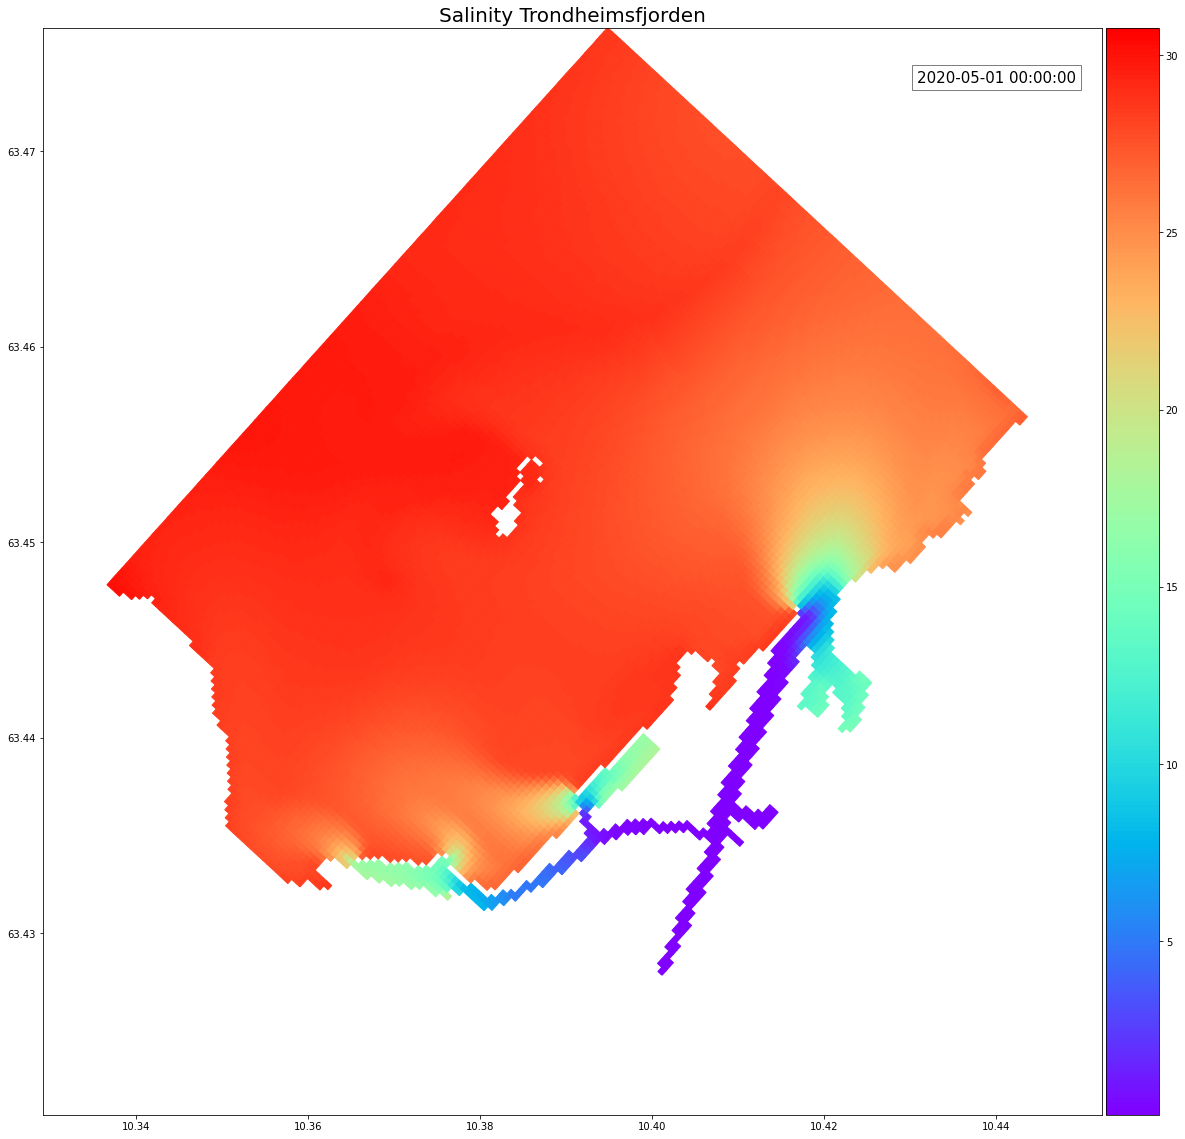

In [22]:
fig, ax = plt.subplots( figsize=(20,20) )
vmax = nc['salinity'][:,0,:,:].max()
vmin = nc['salinity'][:,0,:,:].min()

#cmap=copy.copy(plt.cm.get_cmap("coolwarm"))
a = nc['salinity'][0,0,:,:]
im = ax.pcolormesh(lon,lat,a,antialiased=True,vmin=vmin,vmax=vmax,cmap='rainbow',shading = 'auto')
#sim = ax.imshow(trond)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax)
ax.set_title('Salinity Trondheimsfjorden',fontsize = 20)

title = ax.text(0.9,0.95, "{}".format(timestamps[0]), fontsize= 15, bbox={'facecolor':'w', 'alpha':0.5, 'pad':5},
                transform=ax.transAxes, ha="center")


In [17]:
a = nc['salinity'][0,:,:,:]

In [18]:
    fig = make_subplots(rows=1, cols=1,
                    specs=[[{'type': 'volume'}]],
                    subplot_titles=("Trondheimsfjorden"))
    fig.add_trace(
        go.Volume(
            x=slon,
            y=slat,
            z=-szll,
            value=a,
            opacity=0.2, # needs to be small to see through all surfaces
            surface_count=1,
            colorscale='rainbow',
            slices_z=dict(show=True, fill= 1, locations=[(-szll.min(), - szll.max())]),
            slices_y=dict(show=True, fill= 1, locations=[slat.min(),slat.max()]),
            slices_x=dict(show=True, fill= 1, locations=[slon.min(), slon.max()]),
            caps= dict(x_show=False, y_show=False, z_show=True)),
        row=1, col=1
    )
    fig.update_layout(
        autosize=False,
        width=1920,
        height=810,
        showlegend=False,
        scene1=dict( 
            camera=dict(
                eye=dict(x=1.45,
                         y=-1.45,
                         z=1.25)
                )
        )
    )
    fig.write_html("test.html")

In [5]:
rel = data
rel.shape

(40500, 144)

In [6]:
gamma = 1 
beta = 1
sigma = 1

In [7]:
vv = np.ones((M*N*P,6,3))
from ah3d2 import AH

In [8]:
def createHs(vv, gamma=gamma,beta=beta):
    H = gamma*np.eye(3)  + beta*(vv[:,:,:,np.newaxis]*vv[:,:,np.newaxis,:])
    return(H)

def sp_rnorm(L,n = 1, sigma = sigma):
    res = np.zeros((L.L().shape[0],n))
    for i in range(n):
        z = np.random.normal(size = L.L().shape[0])
        res[:,i] = L.apply_Pt(L.solve_Lt(z,use_LDLt_decomposition=False)) + np.random.normal(size = L.L().shape[0])*sigma
    return(res)

def dinv(M): 
    return(sparse.diags(1/M.diagonal()))

def sp_cov(Q,k): 
    ik = np.zeros(M*N*P)
    ik[k] = 1
    cov = Q.solve_A(ik)
    return(cov)

def rcvQ(Q):
    Q = Q.tocoo()
    return(Q.row,Q.col,Q.data)

def rqinv(Q):
    r, c, v = rcvQ(Q)
    tmpQinv = np.array(robj.r["as.data.frame"](robj.r["summary"](robj.r["inla.qinv"](robj.r["sparseMatrix"](i = robj.FloatVector(r+1),j = robj.FloatVector(c+1),x = robj.FloatVector(v))))))
    return(sparse.csc_matrix((np.array(tmpQinv[2,:],dtype = "float32"), (np.array(tmpQinv[0,:]-1,dtype="int32"), np.array(tmpQinv[1,:]-1,dtype="int32"))), shape=(M*N*P, M*N*P)))


## Stationary Complex Anisotropic Intercept

In [9]:
par = np.genfromtxt('parameters/params_3D_ani_complex_func.csv',delimiter=',')

In [10]:
print("The log-likelihood of this model is %.3f"%par[9])

The log-likelihood of this model is 116895.946


In [71]:
Hs = createHs(np.ones(vv.shape)*[par[4],par[5],0],gamma=[np.exp(par[1]),np.exp(par[1]),np.exp(par[2])],beta = 1)
A_H = AH(M,N,P,Hs,hx,hy,hz)
Ah = sparse.csc_matrix((A_H.Val(), (A_H.Row(), A_H.Col())), shape=(M*N*P, M*N*P))
Dk = np.exp(par[0]) * sparse.eye(M*N*P)
A_mat = Dv@Dk - Ah
Q = A_mat.transpose()@iDv@A_mat
Q_fac = cholesky(Q)
Qinv = rqinv(Q)

In [61]:
def func(x,par=par):
        return(par[6] - par[7]*np.exp(-par[8]*x))

In [288]:
cMu  = func(sz)
locs = np.array([[0,0],
                 [5,3],
                 [10,5],
                 [16,6],
                 [23,10],
                 [30,9],
                 [35,13],
                 [36,18],
                 [33,23],
                 [32,28],
                 [30,34],
                 [25,35],
                 [18,36],
                 [14,32],
                 [8,28]])
s = locs[locs.shape[0]-1,:]

In [214]:
ks = int(s[1]*M*P + s[0]*P + 0)
F = np.zeros(M*N*P)
F[ks] = 1
V = Q_fac.solve_A(F.transpose())
W = F@V + 1/np.exp(par[3])
U = V/W
c = F@cMu - rel[ks,0]
cMu = cMu - U.transpose()*c
Q[ks,ks] = Q[ks,ks] + np.exp(par[3])
Q_fac = cholesky(Q)
Qinv = rqinv(Q)

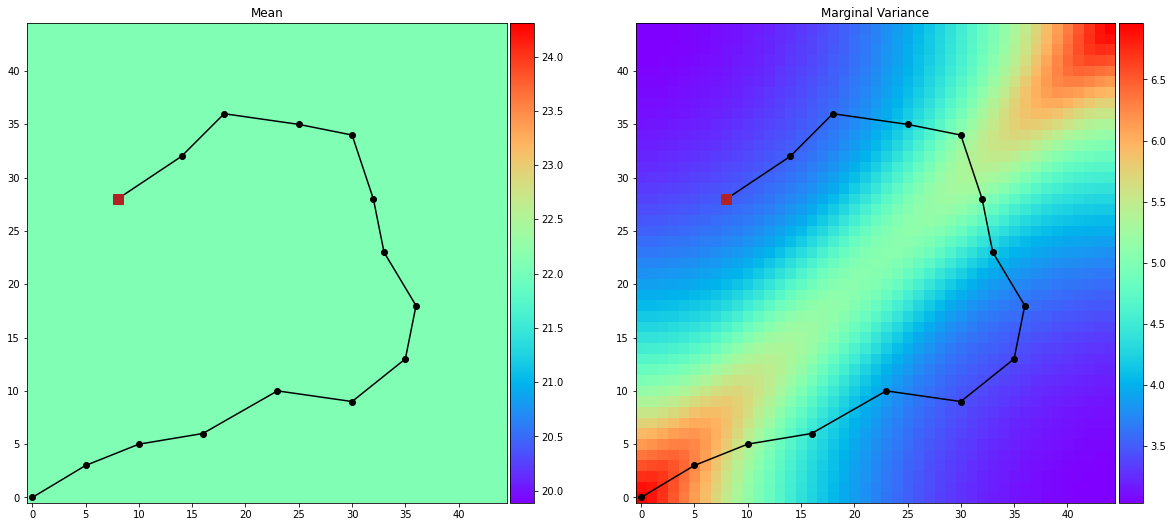

In [289]:

fig, ax = plt.subplots(nrows = 1,ncols = 2,figsize = (20,10))
im1 = ax[0].imshow(cMu.reshape(M,N,P)[:,:,0],cmap="rainbow", origin= "lower")
divider1 = make_axes_locatable(ax[0])
ax[0].plot(locs[:,0],locs[:,1],'-ok')
ax[0].plot(s[0],s[1],marker = "s",color = "firebrick",markersize=10)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
ax[0].set_title('Mean')
fig.colorbar(im1,cax=cax1)
im2 = ax[1].imshow(Qinv.diagonal().reshape(M,N,P)[:,:,0],origin = "lower", cmap="rainbow")
divider2 = make_axes_locatable(ax[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
ax[1].set_title('Marginal Variance')
ax[1].plot(locs[:,0],locs[:,1],'-ok')
ax[1].plot(s[0],s[1],marker = "s",color = "firebrick",markersize=10)
fig.colorbar(im2,cax=cax2);

In [334]:
cMu  = func(sz)
locs = np.array([[0,0],
                 [5,3],
                 [10,5],
                 [16,6],
                 [23,10],
                 [30,9],
                 [35,13],
                 [36,18],
                 [33,23],
                 [32,28],
                 [30,34],
                 [25,35],
                 [18,36],
                 [14,32],
                 [8,28]])

In [321]:
'robot%.f.txt'%1

'robot1.txt'

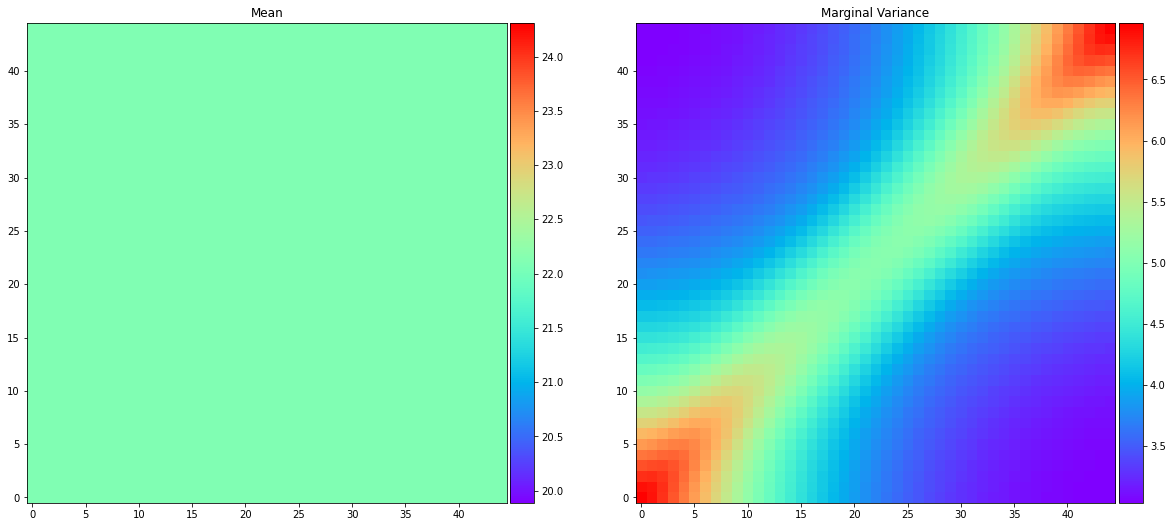

In [330]:
fig, ax = plt.subplots(nrows = 1,ncols = 2,figsize = (20,10))
im1 = ax[0].imshow(cMu.reshape(M,N,P)[:,:,0],cmap="rainbow", origin= "lower")
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
ax[0].set_title('Mean')
fig.colorbar(im1,cax=cax1)
im2 = ax[1].imshow(Qinv.diagonal().reshape(M,N,P)[:,:,0],origin = "lower", cmap="rainbow")
divider2 = make_axes_locatable(ax[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
ax[1].set_title('Marginal Variance')
fig.colorbar(im2,cax=cax2)
fig.savefig('makegifs/robot0.png')

In [ ]:
fig, ax = plt.subplots(nrows = 1,ncols = 2,figsize = (20,10))
im1 = ax[0].imshow(cMu.reshape(M,N,P)[:,:,0],cmap="rainbow", origin= "lower")
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
ax[0].set_title('Mean')
fig.colorbar(im1,cax=cax1)
im2 = ax[1].imshow(Qinv.diagonal().reshape(M,N,P)[:,:,0],origin = "lower", cmap="rainbow")
divider2 = make_axes_locatable(ax[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
ax[1].set_title('Marginal Variance')
fig.colorbar(im2,cax=cax2)
fig.savefig('makegifs/robot0.png')

for i in range(locs.shape[0]):
    paths = locs[0:(i+1),:]
    s = locs[i,:]
    ks = int(s[1]*M*P + s[0]*P + 0)
    F = np.zeros(M*N*P)
    F[ks] = 1
    V = Q_fac.solve_A(F.transpose())
    W = F@V + 1/np.exp(par[3])
    U = V/W
    c = F@cMu - rel[ks,0]
    cMu = cMu - U.transpose()*c
    Q[ks,ks] = Q[ks,ks] + np.exp(par[3])
    Q_fac = cholesky(Q)
    Qinv = rqinv(Q)
    
    fig, ax = plt.subplots(nrows = 1,ncols = 2,figsize = (20,10))
    im1 = ax[0].imshow(cMu.reshape(M,N,P)[:,:,0],cmap="rainbow", origin= "lower")
    divider1 = make_axes_locatable(ax[0])
    ax[0].plot(paths[:,0],paths[:,1],'-ok')
    ax[0].plot(s[0],s[1],marker = "s",color = "firebrick",markersize=10)
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    ax[0].set_title('Mean')
    fig.colorbar(im1,cax=cax1)
    im2 = ax[1].imshow(Qinv.diagonal().reshape(M,N,P)[:,:,0],origin = "lower", cmap="rainbow")
    divider2 = make_axes_locatable(ax[1])
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    ax[1].set_title('Marginal Variance')
    ax[1].plot(paths[:,0],paths[:,1],'-ok')
    ax[1].plot(s[0],s[1],marker = "s",color = "firebrick",markersize=10)
    fig.colorbar(im2,cax=cax2)
    fig.savefig('makegifs/robot%.f.png'%(i+1))
    print('Completed %.2f'%((i+1)/locs.shape[0]))
    

In [72]:
cMu  = rel.mean(axis=(1))
locs = np.array([[0,0,0],
                 [5,3,1],
                 [10,5,2],
                 [16,6,3],
                 [23,10,4],
                 [30,9,5],
                 [35,13,7],
                 [36,18,8],
                 [33,23,9],
                 [32,28,10],
                 [30,34,11],
                 [25,35,12],
                 [18,36,13],
                 [14,32,14],
                 [8,28,15]])
mvar = Qinv.diagonal()
k = 0
l = 24
EP = norm.cdf((l - cMu)/np.sqrt(mvar))
ES = EP > 0.5
BV = EP*(1-EP)

In [73]:
import plotly.io as pio
pio.orca.shutdown_server()

In [74]:
fig = make_subplots(rows=1, cols=2,
                specs=[[{'type': 'volume'},{'type': 'volume'}]],
                subplot_titles=("Mean","Marginal Variance"))

fig.add_trace(
    go.Volume(
        x=sx,
        y=sy,
        z=-sz,
        value=cMu,
        opacity=0.2, # needs to be small to see through all surfaces
        surface_count=1,
        colorscale='rainbow',
        slices_z=dict(show=True, fill= 1, locations=[(-sz.min(), - sz.max())]),
        slices_y=dict(show=True, fill= 1, locations=[sy.min(),sy.max()]),
        slices_x=dict(show=True, fill= 1, locations=[sx.min(), sx.max()]),
        #surface=dict(fill=0.5, pattern='odd'),
        caps= dict(x_show=False, y_show=False, z_show=False),
        colorbar_x=0.45),
    row=1, col=1
)



fig.add_trace(
    go.Volume(
        x=sx,
        y=sy,
        z=-sz,
        value=mvar,
        opacity=0.2, # needs to be small to see through all surfaces
        surface_count=1,
        colorscale='rainbow',
        slices_z=dict(show=True, fill= 1, locations=[(-sz.min(), - sz.max())]),
        slices_y=dict(show=True, fill= 1, locations=[sy.min(),sy.max()]),
        slices_x=dict(show=True, fill= 1, locations=[sx.min(), sx.max()]),
        #surface=dict(fill=0.5, pattern='odd'),
        caps= dict(x_show=False, y_show=False, z_show=False),
        colorbar_x=0.96),
    row=1, col=2
)
fig.update_layout(
    autosize=False,
    width=1920,
    height=1080,
    showlegend=False,
    scene1=dict( 
        camera=dict(
            eye=dict(x=-1.45,
                     y=-1.45,
                     z=1.25)
            )
    ),
    scene2=dict( 
        camera=dict(
            eye=dict(x=-1.45,
                     y=-1.45,
                     z=1.25)
            )
    )
)
fig.write_image("makegifs/func/MEANVAR%.f.png"%(0),engine="orca")
#fig.write_html("makegifs/func/MEANVAR%.f.html"%(0))

In [75]:
fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type': 'volume'},{'type': 'volume'}]],
                    subplot_titles=("Excursion Set","Bernoulli Variance"))


fig.add_trace(
    go.Volume(
        x=sx,
        y=sy,
        z=-sz,
        value=ES,
        opacity=0.2, # needs to be small to see through all surfaces
        surface_count=1,
        colorscale=[ "navy","aquamarine"],
        slices_z=dict(show=True, fill= 1, locations=[(-sz.min(), - sz.max())]),
        slices_y=dict(show=True, fill= 1, locations=[sy.min(),sy.max()]),
        slices_x=dict(show=True, fill= 1, locations=[sx.min(), sx.max()]),
        #surface=dict(fill=0.5, pattern='odd'),
        caps= dict(x_show=False, y_show=False, z_show=False),
        colorbar_x=0.49),
    row=1, col=1
)


fig.add_trace(
    go.Volume(
        x=sx,
        y=sy,
        z=-sz,
        value=BV,
        opacity=0.2, # needs to be small to see through all surfaces
        surface_count=1,
        colorscale='rainbow',
        slices_z=dict(show=True, fill= 1, locations=[(-sz.min(), - sz.max())]),
        slices_y=dict(show=True, fill= 1, locations=[sy.min(),sy.max()]),
        slices_x=dict(show=True, fill= 1, locations=[sx.min(), sx.max()]),
        #surface=dict(fill=0.5, pattern='odd'),
        caps= dict(x_show=False, y_show=False, z_show=False),
        colorbar_x=0.99),
    row=1, col=2
)


fig.update_layout(
    autosize=False,
    width=1920,
    height=1080,
    showlegend=False,
    scene1=dict( 
        camera=dict(
            eye=dict(x=-1.45,
                     y=-1.45,
                     z=1.25)
            )
    ),
    scene2=dict( 
        camera=dict(
            eye=dict(x=-1.45,
                     y=-1.45,
                     z=1.25)
            )
    )
)
fig.write_image("makegifs/func/ESEP3D%.f.png"%(0),engine="orca")
#fig.write_html("makegifs/func/ESEP3D%.f.html"%(0))

In [76]:
for k in range(0,locs.shape[0]):
    pio.orca.shutdown_server()
    s = locs[k,:]
    paths = locs[0:(k+1),:]
    k_paths = paths[:,1]*M*P + paths[:,0]*P + paths[:,2]
    ks = int(s[1]*M*P + s[0]*P + 0)
    F = np.zeros(M*N*P)
    F[ks] = 1
    V = Q_fac.solve_A(F.transpose())
    W = F@V + 1/np.exp(par[3])
    U = V/W
    c = F@cMu - rel[ks,0]
    cMu = cMu - U.transpose()*c
    Q[ks,ks] = Q[ks,ks] + np.exp(par[3])
    Q_fac = cholesky(Q)
    Qinv = rqinv(Q)
    mvar = Qinv.diagonal()
    EP = norm.cdf((l - cMu)/np.sqrt(mvar))
    ES = EP > 0.5
    BV = EP*(1-EP)
    plotly3D(sx,sy,sz,cMu, mvar,k_paths,"makegifs/func/MEANVAR%.f.png"%(k+1))
    plotly3DESEP(sx,sy,sz,EP,ES,BV,k_paths,"makegifs/func/ESEP3D%.f.png"%(k+1))

Stored image successfully
Stored image successfully
Stored image successfully
Stored image successfully
Stored image successfully
Stored image successfully
Stored image successfully
Stored image successfully
Stored image successfully
Stored image successfully
Stored image successfully
Stored image successfully
Stored image successfully
Stored image successfully
Stored image successfully
Stored image successfully
Stored image successfully
Stored image successfully
Stored image successfully
Stored image successfully
Stored image successfully
Stored image successfully
Stored image successfully
Stored image successfully
Stored image successfully
Stored image successfully
Stored image successfully
Stored image successfully
Stored image successfully
Stored image successfully


In [66]:
def plotly3D(sx,sy,sz,cMu, mvar,k_paths,filepath=""):
    fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type': 'volume'},{'type': 'volume'}]],
                    subplot_titles=("Mean","Marginal Variance"))
    
    fig.add_trace(
        go.Volume(
            x=sx,
            y=sy,
            z=-sz,
            value=cMu,
            opacity=0.2, # needs to be small to see through all surfaces
            surface_count=1,
            colorscale='rainbow',
            slices_z=dict(show=True, fill= 1, locations=[(-sz.min(), - sz.max())]),
            slices_y=dict(show=True, fill= 1, locations=[sy.min(),sy.max()]),
            slices_x=dict(show=True, fill= 1, locations=[sx.min(), sx.max()]),
            #surface=dict(fill=0.5, pattern='odd'),
            caps= dict(x_show=False, y_show=False, z_show=False),
            colorbar_x=0.49),
        row=1, col=1
    )



    fig.append_trace(
        go.Scatter3d(
            x=np.array(sx[k_paths]), y=np.array(sy[k_paths]), z=-np.array(sz[k_paths]),
            marker=dict(
                size=4,
                color='black',
            ),
            line=dict(
                color='black',
                width=2
            )
        ),
        row=1, col=1
    )


    fig.add_trace(
        go.Volume(
            x=sx,
            y=sy,
            z=-sz,
            value=mvar,
            opacity=0.2, # needs to be small to see through all surfaces
            surface_count=1,
            colorscale='rainbow',
            slices_z=dict(show=True, fill= 1, locations=[(-sz.min(), - sz.max())]),
            slices_y=dict(show=True, fill= 1, locations=[sy.min(),sy.max()]),
            slices_x=dict(show=True, fill= 1, locations=[sx.min(), sx.max()]),
            #surface=dict(fill=0.5, pattern='odd'),
            caps= dict(x_show=False, y_show=False, z_show=False),
            colorbar_x=0.99),
        row=1, col=2
    )

    fig.append_trace(
        go.Scatter3d(
            x=np.array(sx[k_paths]), y=np.array(sy[k_paths]), z=-np.array(sz[k_paths]),
            marker=dict(
                size=4,
                color='black',
            ),
            line=dict(
                color='black',
                width=2
            )
        ),
        row=1, col=2
    )

    fig.update_layout(
        autosize=False,
        width=1920,
        height=1080,
        showlegend=False,
        scene1=dict( 
            camera=dict(
                eye=dict(x=-1.45,
                         y=-1.45,
                         z=1.25)
                )
        ),
        scene2=dict( 
            camera=dict(
                eye=dict(x=-1.45,
                         y=-1.45,
                         z=1.25)
                )
        )
    )
    if filepath == "":
        print("Filepath not specified! Could not store image.")
    else:
        fig.write_image(filepath,engine="orca")
        print("Stored image successfully")

In [70]:
def plotly3DESEP(sx,sy,sz,EP,ES,BV,k_paths,filepath = ""):
    fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type': 'volume'},{'type': 'volume'}]],
                    subplot_titles=("Excursion Set","Bernoulli Variance"))


    fig.add_trace(
        go.Volume(
            x=sx,
            y=sy,
            z=-sz,
            value=ES,
            opacity=0.2, # needs to be small to see through all surfaces
            surface_count=1,
            colorscale=[ "navy","aquamarine"],
            slices_z=dict(show=True, fill= 1, locations=[(-sz.min(), - sz.max())]),
            slices_y=dict(show=True, fill= 1, locations=[sy.min(),sy.max()]),
            slices_x=dict(show=True, fill= 1, locations=[sx.min(), sx.max()]),
            #surface=dict(fill=0.5, pattern='odd'),
            caps= dict(x_show=False, y_show=False, z_show=False),
            colorbar_x=0.49),
        row=1, col=1
    )

    fig.append_trace(
        go.Scatter3d(
            x=np.array(sx[k_paths]), y=np.array(sy[k_paths]), z=-np.array(sz[k_paths]),
            marker=dict(
                size=4,
                color='black',
            ),
            line=dict(
                color='black',
                width=2
            )
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Volume(
            x=sx,
            y=sy,
            z=-sz,
            value=BV,
            opacity=0.2, # needs to be small to see through all surfaces
            surface_count=1,
            colorscale='rainbow',
            slices_z=dict(show=True, fill= 1, locations=[(-sz.min(), - sz.max())]),
            slices_y=dict(show=True, fill= 1, locations=[sy.min(),sy.max()]),
            slices_x=dict(show=True, fill= 1, locations=[sx.min(), sx.max()]),
            #surface=dict(fill=0.5, pattern='odd'),
            caps= dict(x_show=False, y_show=False, z_show=False),
            colorbar_x=0.99),
        row=1, col=2
    )

    fig.append_trace(
        go.Scatter3d(
            x=np.array(sx[k_paths]), y=np.array(sy[k_paths]), z=-np.array(sz[k_paths]),
            marker=dict(
                size=4,
                color='black',
            ),
            line=dict(
                color='black',
                width=2
            )
        ),
        row=1, col=2
    )

    fig.update_layout(
        autosize=False,
        width=1920,
        height=1080,
        showlegend=False,
        scene1=dict( 
            camera=dict(
                eye=dict(x=-1.45,
                         y=-1.45,
                         z=1.25)
                )
        ),
        scene2=dict( 
            camera=dict(
                eye=dict(x=-1.45,
                         y=-1.45,
                         z=1.25)
                )
        )
    )
    if filepath == "":
        print("Filepath not specified! Could not store image.")
    else:
        fig.write_image(filepath,engine="orca")
        print("Stored image successfully")

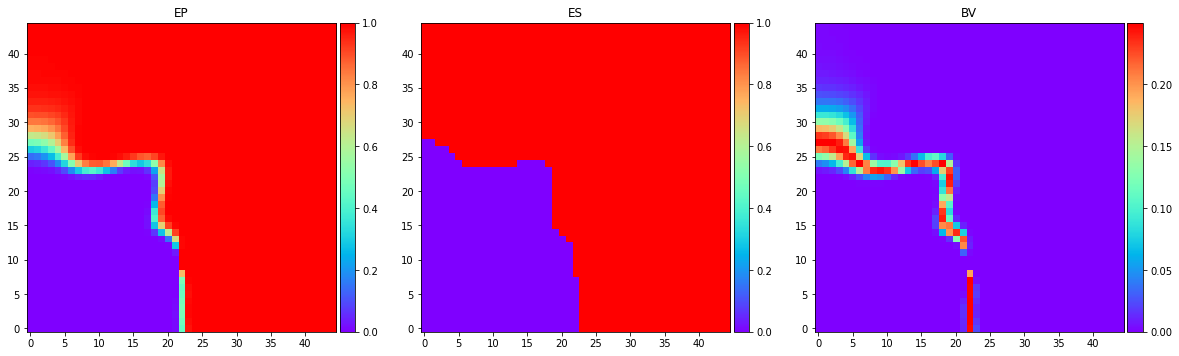

In [69]:
fig, ax = plt.subplots(nrows = 1,ncols = 3,figsize = (20,10))
im1 = ax[0].imshow(EP.reshape(M,N,P)[:,:,0],cmap="rainbow", origin= "lower")
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
ax[0].set_title('EP')
fig.colorbar(im1,cax=cax1)
im2 = ax[1].imshow(ES.reshape(M,N,P)[:,:,0],origin = "lower", cmap="rainbow")
divider2 = make_axes_locatable(ax[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
ax[1].set_title('ES')
fig.colorbar(im2,cax=cax2)
im3 = ax[2].imshow(BV.reshape(M,N,P)[:,:,0],cmap="rainbow", origin= "lower")
divider3 = make_axes_locatable(ax[2])
cax3 = divider3.append_axes("right", size="5%", pad=0.05)
ax[2].set_title('BV')
fig.colorbar(im3,cax=cax3)

In [70]:
from scipy.stats import multivariate_normal as mvn

In [552]:
tsh = 2 # In case we want to generalize later (see Proposition 2).

id_h = sparse.eye(tsh)
full_h = np.ones((tsh,tsh))
cor_h = sparse.csc_matrix(id_h- full_h)

In [580]:
covariance2 = sparse.kron(id_h, sparse.diags(mvar)) + sparse.kron(cor_h, sparse.diags(mvar-mvar2))

In [581]:
covariance2.shape

(81000, 81000)

In [575]:
mean_cat = np.concatenate(tsh * [cMu])
lower_cat = np.concatenate(tsh * [l*np.ones(cMu.shape)])

### Adding decision making

In [77]:
par = np.genfromtxt('parameters/params_3D_ani_complex_ta.csv',delimiter=',')

In [78]:
par

array([-8.39389780e+00, -2.55923782e-03, -4.45382552e+00,  1.25061898e+01,
       -1.62286520e+01, -1.73700634e+01,  1.13882311e+05])

In [79]:
Hs = createHs(np.ones(vv.shape)*[par[4],par[5],0],gamma=[np.exp(par[1]),np.exp(par[1]),np.exp(par[2])],beta = 1)
A_H = AH(M,N,P,Hs,hx,hy,hz)
Ah = sparse.csc_matrix((A_H.Val(), (A_H.Row(), A_H.Col())), shape=(M*N*P, M*N*P))
Dk = np.exp(par[0]) * sparse.eye(M*N*P)
A_mat = Dv@Dk - Ah
Q = A_mat.transpose()@iDv@A_mat
Q_fac = cholesky(Q)
mvar = rqinv(Q).diagonal()
l = 24
cMu = rel.mean(axis=(1))
#cMu  = func(sz)

In [80]:
def cov_reduction(s,newQ):
    ks = int(s[1]*M*P + s[0]*P + s[2])
    newQ[ks,ks] = newQ[ks,ks] + np.exp(par[3])
    return(rqinv(newQ).diagonal(),newQ)
    # return(neighbour_cov, newQ)


def EBV_reduction(cMu,newMvar,cMvar):
    cov_red = np.zeros(cMu.shape)
    for i in range(cov_red.shape[0]):
        cov_red[i] = mvn.cdf([l,l], mean = [cMu[i],cMu[i]],cov = np.array([[cMvar[i], cMvar[i]- newMvar[i]],[cMvar[i]- newMvar[i],cMvar[i]]]))
    return(cov_red)

def EIBV(s,cMu,cQ,cMvar):
    newMvar, newQ = cov_reduction(s,cQ.copy())
    ebv1 = norm.cdf((l - cMu)/np.sqrt(newMvar))
    ebv2 = EBV_reduction(cMu,newMvar,cMvar)
    newEIBV = np.sum(ebv1-ebv2)
    return(newEIBV, newMvar, newQ)


def run_myopic(n_steps, s0, cMvar, cQ, cMu):
    s = s0
    path = s
    ks = int(s[1]*M*P + s[0]*P + s[2])
    k_path = ks
    cQ_fac = cholesky(cQ)
    F = np.zeros(M*N*P)
    F[ks] = 1
    V = cQ_fac.solve_A(F.transpose())
    W = F@V + 1/np.exp(par[3])
    U = V/W
    c = F@cMu - rel[ks,0]
    cMu = cMu - U.transpose()*c
    cQ[ks,ks] = cQ[ks,ks] + np.exp(par[3])
    cQ_fac = cholesky(cQ)
    cMvar = rqinv(cQ).diagonal()
    cEP = norm.cdf((l - cMu)/np.sqrt(cMvar))
    cES = cEP > 0.5
    cBV = cEP*(1-cEP)
    pio.orca.shutdown_server()
    for t in range(n_steps):
        neighs = find_neighbours(s)
        maxEIBV = np.inf
        maxMvar = cMvar
        maxQ = cQ.copy()
        for i in range(neighs.shape[0]):
            newEIBV, newMvar, newQ = EIBV(neighs[i,:],cMu,cQ.copy(),cMvar)
            if (newEIBV < maxEIBV):
                maxEIBV = newEIBV
                maxMvar = newMvar
                maxQ = newQ.copy()
                maxS = neighs[i,:]
        print("Step ",t," from ", s, " to ", maxS)
        s = maxS
        path = np.append(path,s)
        ks = int(s[1]*M*P + s[0]*P + s[2])
        k_path = np.append(k_path,ks)
        F = np.zeros(M*N*P)
        F[ks] = 1
        V = cQ_fac.solve_A(F.transpose())
        W = F@V + 1/np.exp(par[3])
        U = V/W
        c = F@cMu - rel[ks,0]
        cMu = cMu - U.transpose()*c
        cQ = maxQ.copy()
        cMvar = maxMvar
        cQ_fac = cholesky(cQ)
        cEP = norm.cdf((l - cMu)/np.sqrt(cMvar))
        cES = cEP > 0.5
        cBV = cEP*(1-cEP)
        pio.orca.shutdown_server()
        plotly3DESEP(sx,sy,sz,cEP,cES,cBV,k_path,"makegifs/auv-decisions/AUV-dec-ExProbExSet%.f.png"%(t+1))
        plotly3D(sx,sy,sz,cMu, cMvar,k_path,"makegifs/auv-decisions/AUV-dec-MeanCov%.f.png"%(t+1))
    return(path.reshape(int(path.shape[0]/3),3),cQ_fac,cQ,cMvar)

def find_neighbours(s):
    neighs = np.array([])
    if ((s[0]-1) >= 0):
        neighs = np.append(neighs,[s[0] - 1, s[1], s[2]])
        if ((s[1] - 1) >= 0):
            neighs = np.append(neighs,[s[0] - 1, s[1] - 1, s[2]])
            if ((s[2] - 1) >= 0):
                neighs = np.append(neighs,[s[0] - 1, s[1] - 1, s[2]-1])
            if ((s[2] + 1) <= P):
                neighs = np.append(neighs,[s[0] - 1, s[1] - 1, s[2]+1])
        if ((s[1] + 1) <= N):
            neighs = np.append(neighs,[s[0] - 1, s[1] + 1, s[2]])
            if ((s[2] - 1) >= 0):
                neighs = np.append(neighs,[s[0] - 1, s[1] + 1, s[2] - 1])
            if ((s[2] + 1) <= P):
                neighs = np.append(neighs,[s[0] - 1, s[1] + 1, s[2] + 1])
        if ((s[2] - 1) >= 0):
            neighs = np.append(neighs,[s[0] - 1, s[1], s[2] - 1])
        if ((s[2] + 1) <= P):
            neighs = np.append(neighs,[s[0] - 1, s[1], s[2] + 1])
    if ((s[0] + 1) <= M):
        neighs = np.append(neighs,[s[0] + 1, s[1], s[2]])
        if ((s[1] - 1) >= 0):
            neighs = np.append(neighs,[s[0] + 1, s[1] - 1, s[2]])
            if ((s[2] - 1) >= 0):
                neighs = np.append(neighs,[s[0] + 1, s[1] - 1, s[2]-1])
            if ((s[2] + 1) <= P):
                neighs = np.append(neighs,[s[0] + 1, s[1] - 1, s[2]+1])
        if ((s[1] + 1) <= N):
            neighs = np.append(neighs,[s[0] + 1, s[1] + 1, s[2]])
            if ((s[2] - 1) >= 0):
                neighs = np.append(neighs,[s[0] + 1, s[1] + 1, s[2] - 1])
            if ((s[2] + 1) <= P):
                neighs = np.append(neighs,[s[0] + 1, s[1] + 1, s[2] + 1])
        if ((s[2] - 1) >= 0):
            neighs = np.append(neighs,[s[0] + 1, s[1], s[2] - 1])
        if ((s[2] + 1) <= P):
            neighs = np.append(neighs,[s[0] + 1, s[1], s[2] + 1])
    if ((s[1]-1) >= 0):
        neighs = np.append(neighs,[s[0] , s[1] - 1, s[2]])
        if ((s[2] - 1 >= 0)):
            neighs = np.append(neighs,[s[0] , s[1] - 1, s[2] - 1])
        if ((s[2] + 1 <= P)):
            neighs = np.append(neighs,[s[0] , s[1] - 1, s[2] + 1])
    if ((s[1]+1) <= N):
        neighs = np.append(neighs,[s[0] , s[1] + 1, s[2]])
        if ((s[2] - 1 >= 0)):
            neighs = np.append(neighs,[s[0] , s[1] + 1, s[2] - 1])
        if ((s[2] + 1 <= P)):
            neighs = np.append(neighs,[s[0] , s[1] + 1, s[2] + 1])
    if ((s[2]-1) >= 0):
        neighs = np.append(neighs,[s[0] , s[1], s[2] - 1])
    if ((s[2]+1) <= P):
        neighs = np.append(neighs,[s[0] , s[1], s[2] + 1])
    neighs = neighs.reshape(int(neighs.shape[0]/3),3)
    return(neighs)
    

In [83]:
np.savetxt("data/optimpath_1.csv", npaths, delimiter=",")

In [81]:
npaths, nQ_fac, nQ, nMvar = run_myopic(n_steps = 80, s0 = np.array([0,0,0]), cMvar = mvar, cQ = Q, cMu = cMu)

Step  0  from  [0 0 0]  to  [1. 1. 1.]
Stored image successfully
Stored image successfully
Step  1  from  [1. 1. 1.]  to  [2. 0. 2.]
Stored image successfully
Stored image successfully
Step  2  from  [2. 0. 2.]  to  [3. 0. 2.]
Stored image successfully
Stored image successfully
Step  3  from  [3. 0. 2.]  to  [4. 0. 3.]
Stored image successfully
Stored image successfully
Step  4  from  [4. 0. 3.]  to  [5. 0. 3.]
Stored image successfully
Stored image successfully
Step  5  from  [5. 0. 3.]  to  [6. 0. 2.]
Stored image successfully
Stored image successfully
Step  6  from  [6. 0. 2.]  to  [7. 1. 3.]
Stored image successfully
Stored image successfully
Step  7  from  [7. 1. 3.]  to  [8. 0. 2.]
Stored image successfully
Stored image successfully
Step  8  from  [8. 0. 2.]  to  [9. 0. 1.]
Stored image successfully
Stored image successfully
Step  9  from  [9. 0. 1.]  to  [10.  0.  2.]
Stored image successfully
Stored image successfully
Step  10  from  [10.  0.  2.]  to  [11.  0.  3.]
Stored imag